# Wasserstein Generative Adversarial Network
I built a GAN_GP for generating flower images.


In [1]:
# Import TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, metrics, losses
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# check whether GPU is avaiable to use
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available:  1
Thu Jan  2 01:19:35 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--

## 1. Dataset Preparation


## To Run in Google Colab

In [3]:
import zipfile
import os

from google.colab import drive
drive.mount('/content/drive')

# List MyDrive before t
!ls /content/drive/MyDrive/



# Open dataset from zipfile
zip_path = "/content/drive/MyDrive/flowers.zip"
extract_path = '/content/drive/MyDrive/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")



# lists all files in Google Drive
!ls /content/drive/MyDrive/

Mounted at /content/drive
flowers.zip  WGAN.ipynb
Dataset unzipped successfully!
flowers_train_validation  flowers.zip  WGAN.ipynb


## Run on Local Machine

In [4]:
'''

import os
import zipfile

# Define the paths for the zip file and extraction directory
zip_path = r"C:\path\to\your\flowers.zip"  # Update this to your zip file's actual path
extract_path = r"C:\path\to\extract\directory"  # Update this to your desired extraction directory

# Ensure the extraction path exists
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset unzipped successfully!")
except FileNotFoundError:
    print(f"Error: The file {zip_path} does not exist.")
except zipfile.BadZipFile:
    print(f"Error: The file {zip_path} is not a valid zip file.")

'''


'\n\nimport os\nimport zipfile\n\n# Define the paths for the zip file and extraction directory\nzip_path = r"C:\\path\to\\your\x0clowers.zip"  # Update this to your zip file\'s actual path\nextract_path = r"C:\\path\to\\extract\\directory"  # Update this to your desired extraction directory\n\n# Ensure the extraction path exists\nos.makedirs(extract_path, exist_ok=True)\n\n# Extract the zip file\ntry:\n    with zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n        zip_ref.extractall(extract_path)\n    print("Dataset unzipped successfully!")\nexcept FileNotFoundError:\n    print(f"Error: The file {zip_path} does not exist.")\nexcept zipfile.BadZipFile:\n    print(f"Error: The file {zip_path} is not a valid zip file.")\n\n'

In [5]:
# Google CoLab
train_dir  = '/content/drive/MyDrive/flowers_train_validation'


# Local Machine
#Train = 'C:/path to local drive for extracted files /flowers_train_validation'

TARGET_SIZE=(150,150)

### 1.2: Data Preprocessing

In [6]:
IMAGE_SIZE = 64
CHANNELS = 3
NUM_FEATURES = 128
Z_DIM = 50
BATCH_SIZE = 128
input_shape = (64,64, 3)
BETA = 1
latent_dim = 50
codings_size = 50
img_shape = (64,64, 3)

### 1.2: Data Preprocessing

#### 1.2.1 Using image_dataset_from_directory for constructing training dataset

**Read image_dataset_from_directory**:

- Set the image_size to be (64, 64).
- Set the batch_size to be 128.

In [7]:
# Load the train data
# We only use training dataset to build our VAE model
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,  # this is the train dataset folder on your google colab
    color_mode= "rgb",
    image_size= (64,64),
    batch_size=128,
    labels=None,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

print(type(train_data))

Found 4323 files.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#### 1.2.2 Preprocessing images

**Preprocessing image**

Preprocess the imput image so that it is normalized into the value between (-1, 1) *i.e.*, the original pixel value should be subtracted from 127.5 and then divided by 127.5, and then return the normalized image back.


In [8]:
# Preprocess the data below
def preprocess(img):
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5
    return img

In [9]:
# the training dataset has been processed for model training
train_data = train_data.map(lambda x: preprocess(x))

### 1.3 Checking train data



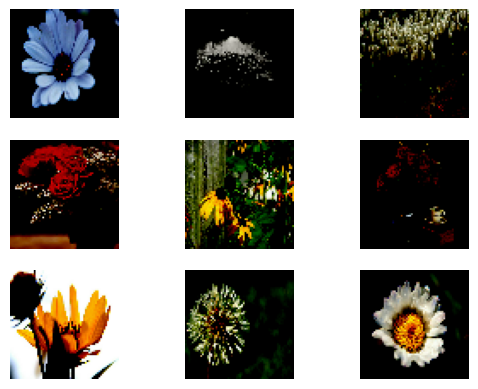

In [10]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for batch in train_data.take(1):
    # Iterate through images in the batch
    for i in range(9):  # Show 9 images for preview
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy().clip(0, 1))  # Clip values to [0, 1] range
        plt.axis('off')
    plt.show()


## 2. Define the WGAN_GP Model

### 2.1 The Generator

**Generator**:

- **The Generator Architecture**.  The Generator Architecture is very similar to decoder in VAE, that is, using transposed convolutional layers (Conv2DTranspose).
- **Activation Functions**. The final layer should use an activation function that matches the data characteristics, i.e., *tanh* for pixel values in the range [-1, 1]. Intermediate layers can use ReLU or LeakyReLU.
- **Final Output Layer**: In general, it should have the same number of channels and spatial dimensions as the original input image i.e., **(64, 64 ,3)**. So you need cropping or padding if necessary.
- Suggested input Latent Space **dimension = 50** (don't make it too big as the training set size is only about 3000 vs celeb dataset size = 200,000


In [11]:
# Define the Generator below

# Generator
generator = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)

generator = models.Model(generator, generator_output)
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 512)           │         409,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,169,027 (12.09 MB)

 Trainable params: 3,167,107 (12.08 MB)

 Non-trainable params: 1,920 (7.50 KB)

## 2.2 The Critic

**Critic**:

- **Fully Convolutional Design**: The critic uses convolutional layers to downsample the image gradually.
- **Final Output Layer**: The last layer should only have one node, and we don't have an activation layer since we are implementing WGAN, not GAN.
- **Leaky ReLU Activation**: Helps with gradient flow for low-activation inputs.
- **Gradient Penalty**: Regularizes the critic’s gradient by addding gradient penalty to improve convergence.




In [12]:
# Define the Critic

critic = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)
critic = models.Model(critic, critic_output)
critic.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 1)             │           8,193 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,764,737 (10.55 MB)

 Trainable params: 2,764,737 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

## 2.3 WGAN_GP

**WGAN_GP**:

The WGAN uses:
- *wasserstein_loss*: Measures the Wasserstein distance between real and fake data distributions to guide training.
- *gradient_penalty*: Regularizes the critic's gradients to enforce Lipschitz continuity for stable training.
- *train_step*: Alternates between updating the critic (multiple steps) and generator (single step) to improve both models.



In [13]:
# Define the WGAN_GP model below

class WGAN_GP(Model):
    def __init__(self, generator, critic, clip_value=0.01,n_critic=5, latent_dim=50, batch_size=128):
        super(WGAN_GP, self).__init__()
        self.generator = generator
        self.critic = critic
        self.clip_value = clip_value
        self.n_critic = n_critic
        self.latent_dim = latent_dim
        self.batch_size = batch_size


    def wasserstein_loss(self, y_true, y_pred):
        return tf.reduce_mean(y_true * y_pred)

    def compile(self, generator_optimizer, critic_optimizer, **kwargs):
        super(WGAN_GP, self).compile(**kwargs)
        self.generator_optimizer = generator_optimizer
        self.critic_optimizer = critic_optimizer

    def train_step(self, real_imgs):
        batch_size = tf.shape(real_imgs)[0]
        real_labels = -tf.ones((batch_size, 1))
        fake_labels = tf.ones((batch_size, 1))

        for _ in range(self.n_critic):
            with tf.GradientTape() as critic_tape:
                noise = tf.random.normal((batch_size, self.latent_dim))
                fake_imgs = self.generator(noise)

                real_loss = self.wasserstein_loss(real_labels, self.critic(real_imgs))
                fake_loss = self.wasserstein_loss(fake_labels, self.critic(fake_imgs))

                gp = self.gradient_penalty(real_imgs, fake_imgs)
                d_loss = 0.5 * (real_loss + fake_loss) + 5.0 * gp  # Lambda for GP

            critic_grads = critic_tape.gradient(d_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        with tf.GradientTape() as gen_tape:
            noise = tf.random.normal((batch_size, self.latent_dim))
            fake_imgs = self.generator(noise)
            g_loss = self.wasserstein_loss(real_labels, self.critic(fake_imgs))

        gen_grads = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}


    def gradient_penalty(self, real_imgs, fake_imgs):
      batch_size = tf.shape(real_imgs)[0]
      # Ensure real_imgs and fake_imgs are of the same shape
      fake_imgs = tf.cast(fake_imgs, tf.float32)  # Ensure dtype match
      alpha = tf.random.uniform((batch_size, 1, 1, 1), 0., 1.)
      interpolated = alpha * real_imgs + (1 - alpha) * fake_imgs

      with tf.GradientTape() as gp_tape:
          gp_tape.watch(interpolated)
          interpolated_score = self.critic(interpolated)

      grads = gp_tape.gradient(interpolated_score, [interpolated])[0]
      grad_l2 = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]) + 1e-12)
      gradient_penalty = tf.reduce_mean((grad_l2 - 1.0) ** 2)
      return gradient_penalty

In [14]:
# Initialize and compile WGAN
wgan_gp = WGAN_GP(generator=generator, critic=critic)
wgan_gp.compile(generator_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9),
    critic_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9))

## 3. Model training

In [15]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(np.clip(image, 0, 1))
        plt.axis("off")

**Train the wgan_gp model and generate the faked images**:

**Important**:
- It is computing intensive so the final results may not look good enough if epochs number is small
- Suggested epochs = 100
- You may try large epochs such as 500 if you have GPUs installed on your local machine.

In [16]:
# training your wgan_gp model and display 128 faked images
n_epochs = 100

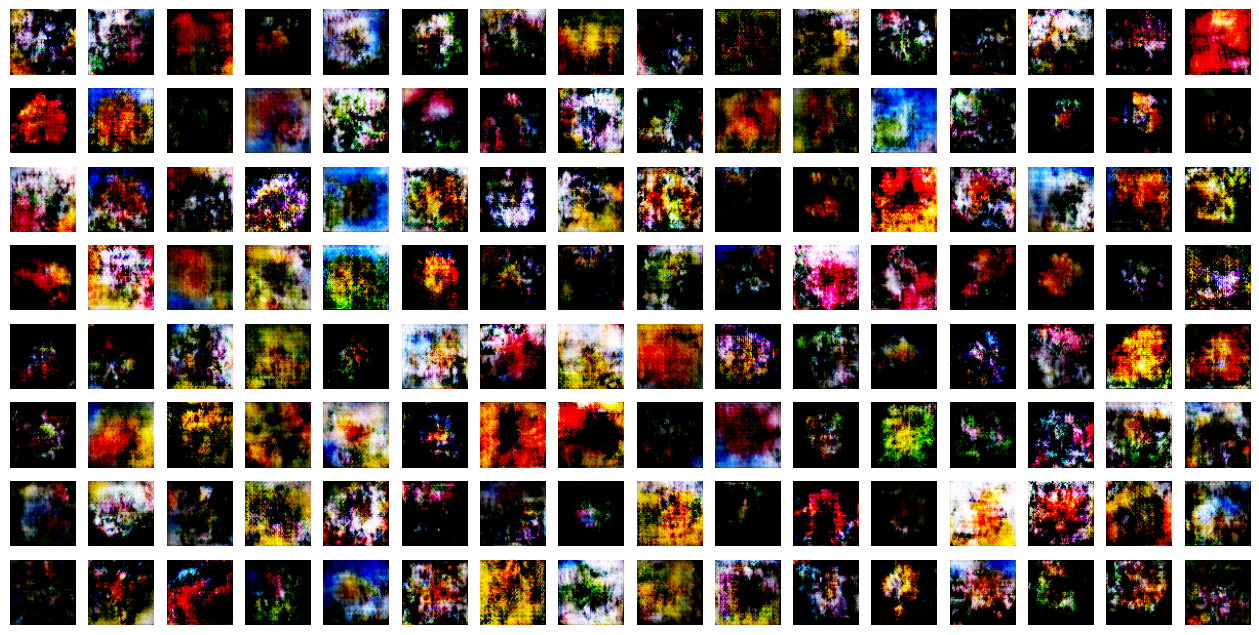

In [17]:
for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))
    for real_images in train_data:
        wgan_gp.train_step(real_images)  # Train the WGAN-GP model
    # Generate and plot fake images after each epoch
    noise = tf.random.normal((128, Z_DIM))
    fake_imgs = wgan_gp.generator(noise)
    plot_results(fake_imgs, 16)
    plt.show()
